# Prep

This blocks installs all the neccesary dependancies, and imports the relevant files

* import tf.models
* install relevant packages 
* import standard dataset
* import additional dataset
* define helper functions


In [1]:
!pip -q install tf_slim
!pip -q install pycocotools
!pip install -q -U tensorflow-addons

!pip install -U --pre tensorflow=="2.2.0"

     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 460kB 97kB/s 
     |████████████████████████████████| 3.0MB 50.7MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [2]:
import tensorflow
print(tensorflow.__version__)

2.2.0


In [3]:
# Import tensorflow.models into the current directory
import os 
import pathlib
import sys

from tqdm.notebook import tqdm

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('...')
elif not pathlib.Path('models').exists():
  print('Downloading from github ... ')
  !git clone --depth 1 https://github.com/tensorflow/models

os.environ['PYTHONPATH'] += ":/content/models"
sys.path.append("/content/models")

In [4]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [5]:
%%bash 
cd models/research
pip -q install .

In [6]:
# Download data from drive into cwd

if 'Data' not in os.listdir():
  !cp "/content/drive/MyDrive/waste_detection/Data/med_res_3.zip" .
  !unzip -q med_res_3.zip -d Data
  # Remove the zip file 
  !rm med_res_3.zip

In [ ]:
folder_names = ['extra_furnitures',
                'extra_mattresses',
                'extra_various',
                'extra_WEEE',
                'extra_tyres',
                'extra_cylinders']

for folder_name in tqdm(folder_names):
  if folder_name not in os.listdir():

    zipfile = folder_name + '.zip'
    path = "/content/drive/My Drive/ML/waste_detection/Data/" + zipfile
    
    !cp '$path' .
    !unzip -q '$zipfile' -d '$folder_name'
    !rm '$zipfile'

In [8]:
import matplotlib
import matplotlib.pyplot as plt

import os
import shutil
import json
import random
import re
import io
import imageio
import cv2
import glob
import scipy.misc
import math
import numpy as np
import tensorflow_addons as tfa
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline


In [9]:
# Helper functions 
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load images into numpy arrays 
def image_to_np(dir, w, h):
  output = [None] * len(os.listdir(dir))
  i = 0
  for file in tqdm(os.listdir(dir)):
    img = load_image_into_numpy_array(dir + file)
    res = cv2.resize(img, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
    output[i] = res
    i += 1
  return output

# Utilizes the visualization_utils
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    threshold = 0.8):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=threshold)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)
  
def split_data(SOURCE, TRAIN_DIR, TEST_DIR, SPLIT_PERCENT, seed = False, FILENAMES=None):

  # Get a list of image names

  if FILENAMES == None:
    files = []
    for filename in os.listdir(SOURCE):
        filepath = SOURCE + filename
        if filepath.endswith('.jpg'):
            files.append(filename)
  else:
    files = FILENAMES

  # Define test and train length
  train_length = int(len(files) * SPLIT_PERCENT)
  test_length = int(len(files)-train_length)

  # Shuffle and split
  if not seed:
    random.seed(1)
    random.shuffle(files)
    training_set = files[0:train_length]
    testing_set = files[-test_length:]
  else:
    training_set = []
    testing_set = []
    for filename in files:
      if filename in seed:
        testing_set.append(filename)
      elif filename not in seed:
        training_set.append(filename)

  # move the files
  for filename in training_set:
      os.replace(SOURCE+filename, TRAIN_DIR + filename)
      # shutil.copyfile(SOURCE+filename, TRAIN_DIR+filename)
  for filename in testing_set:
      os.replace(SOURCE+filename, TEST_DIR + filename)
      # shutil.copyfile(SOURCE+filename, TEST_DIR+filename)


# Move
This block moves the images in place and stores the data in memory

* split images into train and test folders
* all json files are stored in the same folder
* normalize boxes
* store all images as numpy arrays into memory
* convert np arrays into tensors, to be passed into model

In [10]:
# Split data into train and test folders

def extract(label, category):
  if label[category] is not None:
    return np.array(label[category])

current_dir = os.getcwd()
image_path = os.path.join(current_dir, 'Data/med_res_3/images')
label_path = os.path.join(current_dir, 'Data/med_res_3/bboxes')


# bagged_waste
# black_bag_waste
# fridge_or_freezer
# gas_bottle_or_cylinder_and_fire_extinguisher
# mattress
# sofa_or_settee_and_chair
# tv_monitor_and_laptop
# tyre_and_machine_track
# WEEE_large
# skip

label_names = {1: 'bagged_waste',
               2: 'black_bag_waste',
               3: 'fridge_or_freezer',
               4: 'gas_bottle_or_cylinder_and_fire_extinguisher',
               5: 'mattress',
               6: 'sofa_or_settee_and_chair', 
               7: 'tv_monitor_and_laptop',
               8: 'tyre_and_machine_track',
               9: 'WEEE_large'}

category_index = {}
for i in label_names:
  category_index[i] = {'id': i, 'name': label_names[i]}

# Note: fire_extinguishers will be combined with gas_bottles_or_cylinders

valid_jpgs = []

# Select only samples that contain classes from above:
for filepath in os.listdir(image_path):
  filename = filepath.split('/')[-1]
  if filename.endswith('.jpg'):
    json_file = os.path.join(label_path, filename[:-4]+'_bboxs.json')
    with open(json_file, 'r') as file:
      annotation = json.load(file)
      filtered_annotation = np.array([extract(annotation, label_names[i]) for i in label_names])
      for Class in filtered_annotation:
        # Only append if not empty
        if Class is not None:
          valid_jpgs.append(filename)
          break
        # print(annotation[Class])

print(len(os.listdir(image_path)))
print(len(valid_jpgs))

25
0


In [11]:
try: 
  os.mkdir(image_path + '/train')
  os.mkdir(image_path + '/test')
  print('Created train and test directories')
except:
  pass

train_dir = os.path.join(image_path, 'train/')
test_dir = os.path.join(image_path, 'test/')

# test_images = []
# with open('Data/test_set.txt') as seed:
#   for line in seed:
#     test_images.append(line.split('\n')[0])

# Execute moving files
try:
  split_data(image_path+'/', train_dir, test_dir, 0.9, FILENAMES = valid_jpgs)
except OSError:
  print('error raised')
  pass

print('train folder: {}, test folder: {}'.format(len(os.listdir(train_dir)), len(os.listdir(test_dir))))

train folder: 179, test folder: 20


In [ ]:
count = 0
for extra_path in folder_names:
  extra_path += '/'
  extra_image_path = extra_path + 'images/'
  extra_bbox_path = extra_path + 'bboxes/'
  for filepath in os.listdir(extra_image_path):
    filename = filepath.split('/')[-1]
    # print(filename)
    if filename.endswith('.jpg'):
      annotation_file = filename[:-4] + '_bboxs.json'
      if annotation_file in os.listdir(extra_bbox_path):
        with open(extra_bbox_path+annotation_file, 'r') as file:
          annotation = json.load(file)
          filtered_annotation = np.array([extract(annotation, label_names[i]) for i in label_names])
          for Class in filtered_annotation:
            # Only append if not empty
            if Class is not None:
              count += 1
              os.replace(extra_image_path+filename, 'Data/images/train/' + filename)
              os.replace(extra_bbox_path+annotation_file, 'Data/bboxes/' + annotation_file)
              break
        # print(annotation_file)

print('Added {} images'.format(count))
print('train folder: {}, test folder: {}'.format(len(os.listdir(train_dir)), len(os.listdir(test_dir))))

In [12]:
# Load label json files into numpy arrays 

def json_to_np(dir):
  output_boxes = []
  output_classes = []
  for i, file in enumerate(os.listdir(dir)):
  #     # Get name of the file
      label_file = os.path.join(label_path, file[:-4]+'_bboxs.json')
      with open(label_file, 'r') as file:
        label = json.load(file)

      categories = np.array([extract(label, label_names[i]) for i in label_names])

      boxes = np.array([[0, 0, 0, 0]])
      classes = np.array([])

      for index, category in enumerate(categories):
        if category is not None:
          boxes = np.vstack([boxes, category])
          classes = np.append(classes, np.array([int(index+1)]*len(category)))
    
      output_boxes.append(boxes[1:].astype('float'))
      output_classes.append(classes.astype('int32'))

  return output_boxes, output_classes

difficult_label_dir = 'Data/bboxes_d/'

def json_to_np_d(dir):
  
  output_difficults = []
  for i, file in enumerate(os.listdir(dir)):
  #     # Get name of the file
      label_file = os.path.join(difficult_label_dir, file[:-4]+'_bboxs_d.json')
      with open(label_file, 'r') as file:
        label = json.load(file)

      filtered_annotation = np.array([extract(label, label_names[i]) for i in label_names])

      difficults = np.array([])

      for index, category in enumerate(filtered_annotation):
        if category is not None:
          for box in category:
            difficults = np.append(difficults, box[1])

      output_difficults.append(difficults.astype('int32'))

  return output_difficults

y_train_boxes, y_train_classes = json_to_np(train_dir)
y_test_boxes, y_test_classes = json_to_np(test_dir)
# y_test_difficults = json_to_np_d(test_dir)

In [13]:
# Normalize the labels 

# width: 420, height: 312
# Data format right now: [xmin, ymin, xmax, ymax]
# Target format         : [ymin, xmin, ymax, xmax]

orig_width = 640
orig_height = 640

target_width = orig_width
target_height = orig_height

def normalize_boxes(labels):
  for label in labels:
    for box in label:
      box[0], box[1], box[2], box[3] = box[1], box[0], box[3], box[2]
  return labels

y_train_boxes = normalize_boxes(y_train_boxes)
y_test_boxes = normalize_boxes(y_test_boxes)

print(y_test_boxes[0])

[[0.677885 0.129854 0.879808 0.315534]
 [0.74359  0.485437 0.879808 0.667476]
 [0.5625   0.597087 0.713141 0.726942]
 [0.19391  0.271845 0.735577 0.764563]
 [0.141026 0.097087 0.599359 0.509709]]


In [14]:
# Merge Classes + distribution Summary

distribution_train = {}
distribution_test = {}
distribution_test_trivial = {}

for i in label_names:
  distribution_train[label_names[i]] = 0
  distribution_test[label_names[i]] = 0
  distribution_test_trivial[label_names[i]] = 0

for annotation in y_train_classes:
  for j, Class in enumerate(annotation):
    distribution_train[label_names[annotation[j]]] += 1

for annotation in y_test_classes:
  for j, Class in enumerate(annotation):
    distribution_test[label_names[annotation[j]]] += 1

print('Train Set')
print(distribution_train)
print('\nTest set')
print(distribution_test)

Train Set
{'bagged_waste': 155, 'black_bag_waste': 555, 'fridge_or_freezer': 17, 'gas_bottle_or_cylinder_and_fire_extinguisher': 156, 'mattress': 13, 'sofa_or_settee_and_chair': 48, 'tv_monitor_and_laptop': 3, 'tyre_and_machine_track': 108, 'WEEE_large': 9}

Test set
{'bagged_waste': 11, 'black_bag_waste': 51, 'fridge_or_freezer': 1, 'gas_bottle_or_cylinder_and_fire_extinguisher': 2, 'mattress': 1, 'sofa_or_settee_and_chair': 1, 'tv_monitor_and_laptop': 0, 'tyre_and_machine_track': 2, 'WEEE_large': 0}


In [15]:
x_train_np = image_to_np(train_dir, target_width, target_height)
print(f'\n Appended and resized {len(x_train_np)} training images')

x_test_np = image_to_np(test_dir, target_width, target_height)
print(f'\n Appended and resized {len(x_test_np)} training images')




 Appended and resized 179 training images




 Appended and resized 20 training images


## np_to_tensors()




In [16]:
# Prepping data, converting np arrays into tensors 

num_classes = 9

def np_to_tensors(image_nps, box_nps, class_nps):
  label_id_offset = 1

  image_tensors = []
  box_tensors = []
  classes_one_hot_tensors = []

  for (image_np, box_np, class_np) in zip(image_nps, box_nps, class_nps):
    image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        image_np, dtype=tf.float32), axis=0))
    
    box_tensors.append(tf.convert_to_tensor(box_np, dtype=tf.float32))
    
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(class_np - label_id_offset, dtype=np.int32)
    classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

  return image_tensors, box_tensors, classes_one_hot_tensors

train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors = np_to_tensors(x_train_np, y_train_boxes, y_train_classes)
test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors = np_to_tensors(x_test_np, y_test_boxes, y_test_classes)

# print('Done prepping data.')

In [18]:
# Optional: visulize images

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

plt.figure(figsize=(30, 15))
for i in range(6):
  offset = 2
  plt.subplot(2, 3, i+1)
  plot_detections(
      cv2.resize(x_train_np[i+ offset], dsize=(421, 320), interpolation=cv2.INTER_CUBIC),
      y_train_boxes[i+ offset],
      y_train_classes[i+ offset],
      np.ones(shape=[y_train_boxes[i+ offset].shape[0]], dtype=np.float16),
      category_index)
plt.axis('off')

plt.show()



Output hidden; open in https://colab.research.google.com to view.

# Load Config

This block creates the model metaArch, and loads untrained weights

* download weights from tensorflow.models
* loads the config file from '/models/research/object_detection/configs'
* restores weights and create a checkpoint instance



In [19]:
# if 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8' not in os.listdir():
#   !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz 
#   !tar -xf ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
#   !rm ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
# !mv ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/


!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!rm ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
# !mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-12-22 16:18:14--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.170.128, 2607:f8b0:400c:c0d::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.170.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   178MB/s    in 1.3s    

2020-12-22 16:18:15 (178 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [20]:
# Configuring and creating the detection model (weight's are not loaded here)

num_classes = 9
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt'

# # raw_checkpoint = checkpoint_path

# pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config'
# checkpoint_path = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt'

raw_checkpoint = checkpoint_path + '-0'


# Load pipeline config and build a detection model architecture (only need to be ran once)

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
    model_config = model_config, is_training=True
)


In [ ]:
# [i.name for i in detection_model.trainable_variables]
# # len(detection_model.trainable_variables)

In [21]:
# Restore weights (original weights)

def restore_weights(ckpt_path, restore_all=True):

  print(f'restoring weights from {str(ckpt_path)}')

  if restore_all:
    ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
    ckpt.restore(ckpt_path).expect_partial()
  
  else:
    fake_box_predictor = tf.compat.v2.train.Checkpoint(
      _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
      _box_prediction_head=detection_model._box_predictor._box_prediction_head
      )

    fake_model = tf.compat.v2.train.Checkpoint(
                _feature_extractor=detection_model._feature_extractor,
                _box_predictor=fake_box_predictor)
  
    ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
    ckpt.restore(ckpt_path).expect_partial()

  # Run model through a dummy image so that variables are created
  image, shapes = detection_model.preprocess(tf.zeros([1, target_height, target_width, 3]))
  prediction_dict = detection_model.predict(image, shapes)
  _ = detection_model.postprocess(prediction_dict, shapes)
  print('Weights restored!')

  return ckpt

# Initialize ckpt
ckpt = restore_weights(raw_checkpoint, restore_all=False)

restoring weights from ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0
Weights restored!


# Functions
This block contains the following functions:

* step function (for both training and evaluating)
* layer extraction function
* main training block (given hyperparameters)

### get_model_train_step_function()


In [43]:
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list,
                    backprop = True):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(len(image_tensors) * [[target_height, target_width, 3]], dtype=tf.int32)

    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)

    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)

      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

      if backprop:
        gradients = tape.gradient(total_loss, vars_to_fine_tune)
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

    return total_loss, detection_model.postprocess(prediction_dict, shapes)

  return train_step_fn

### get_variables()


In [23]:
def get_variables(prefixes_to_train):
  trainable_variables = detection_model.trainable_variables
  to_fine_tune = []
  for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
      to_fine_tune.append(var)
  return to_fine_tune

### train()

In [24]:
def train(epochs, 
          batch_size, 
          train_step_fn, 
          flip_prob = 0.2,
          rotate_prob = 0.2,
          hue_prob = 0.2, 
          crop_prob = 0.2):
  '''
    Performs training given epoch and batch size 

    Note: this function does not generalize, neither x_train_np or labels are passed
    as arguments
  '''

  tf.keras.backend.clear_session()

  num_batches = (len(x_train_np) // batch_size) + 1

  print('Started fine-tuning!', flush=True)

  cv_loss, cv_map = test_evaluate()

  print(f'Initial cv_loss: {cv_loss:.6f}, cv_map: {cv_map:.6f}')

  for e in range(epochs):

    epoch_loss = 0

    all_keys = list(range(len(x_train_np)))
    random.shuffle(all_keys)

    for i in tqdm(range(num_batches)):

      image_list, boxes_list, classes_list = [], [], []

      # Grab keys for a random subset of examples
      example_keys = all_keys[(i*batch_size):((i+1)*batch_size)]

      for key in example_keys:
        temp_image = x_train_np[key]
        temp_box = y_train_boxes[key]
        temp_class = y_train_classes[key]
        
        # Augmentation:
        temp_image, temp_box = random_horizontal_flip(temp_image, temp_box, flip_prob)
        temp_image, temp_box = random_rotate(temp_image, temp_box, rotate_prob)
        temp_image, temp_box = random_hue(temp_image, temp_box, hue_prob)
        temp_image, temp_box, temp_class = random_crop(temp_image, temp_box, temp_class, crop_prob)

        image_list.append(temp_image)
        boxes_list.append(temp_box)
        classes_list.append(temp_class)

      image_tensors, boxes_tensors, classes_tensors = np_to_tensors(image_list, boxes_list, classes_list)

      # Training step (forward pass + backwards pass)
      total_loss, _ = train_step_fn(image_tensors, boxes_tensors, classes_tensors)

      epoch_loss += total_loss.numpy()

    epoch_loss /= num_batches

    cv_loss, cv_map = test_evaluate()
    print('epoch {} of {}, loss= {:.6}, cv_loss = {:.6}, cv_map = {:.6}'.format(e+1, epochs, epoch_loss, cv_loss, cv_map))

  print(f'final cv_loss: {cv_loss :.6}, cv_map: {cv_map :.6}')
  print('Done fine-tuning!')

### test_evaluate()

In [42]:
def test_evaluate():
  batch_size = 5
  loss = 0
  num_batches = len(test_image_tensors) // batch_size
  # train_step_fn(test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors, backprop=False)

  keys = list(range(len(x_test_np)))

  detected_boxes = []
  detected_classes = []
  detected_scores = []

  for i in range(num_batches):
    key_batch = keys[(i*batch_size):((i+1)*batch_size)]
    gt_boxes_list, gt_classes_list, image_tensors = [], [], []

    for key in key_batch:
      image_tensors.append(test_image_tensors[key])
      gt_boxes_list.append(test_gt_box_tensors[key])
      gt_classes_list.append(test_gt_classes_one_hot_tensors[key])

    batch_loss, detections = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list, backprop=False)

    for score, Class, box in zip(detections['detection_scores'], detections['detection_classes'], detections['detection_boxes']):
      detected_score, detected_class, detected_box = filter_from_score(score.numpy(),
                                                                      Class.numpy()+1,
                                                                      box.numpy(),
                                                                      threshold = 0.1)
      detected_boxes.append(detected_box)
      detected_classes.append(detected_class)
      detected_scores.append(detected_score)  

    loss += batch_loss

  _, _, maps = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_test_boxes, 
                          y_test_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5, 
                          suppress_output = True)
  
  map = sum(maps)/num_classes
  return loss.numpy()/num_batches, map

### random_hue()

In [26]:
def random_hue(image_np, boxes, probability):
  if random.random() < probability:
    image_np = tf.image.random_contrast(tf.image.random_hue(tf.image.random_brightness(image_np, 0.2), 0.1), 0.8, 1.2).numpy()
  return image_np, boxes

### random_horizontal_flip()

In [27]:
# Flip box
def flip_box_left_right(boxes):
  tempboxes = boxes.copy()
  for i in range(len(tempboxes)):
    tempboxes[i][1], tempboxes[i][3] = 1 - tempboxes[i][3], 1 - tempboxes[i][1]
    # tempboxes[i][3] = 1 - tempboxes[i][1]
  
  return tempboxes

def random_horizontal_flip(image_np, boxes, probability):
  if random.random() < probability:
    image_np = tf.image.flip_left_right(image_np).numpy()
    boxes = flip_box_left_right(boxes)
  return image_np, boxes

### random_rotate()

In [28]:
def two_points_to_four_points(box):
  coord_1 = (box[0], box[1])
  coord_2 = (box[2], box[1])
  coord_3 = (box[2], box[3])
  coord_4 = (box[0], box[3])
  return([coord_1, coord_2, coord_3, coord_4])

def rotate_coordinates(boxes, alpha):
  output_boxes = []
  for j, box in enumerate(boxes):
    box = two_points_to_four_points(box)
    for i, coord in enumerate(box):
      x_rel = coord[0] - 0.5
      y_rel = 0.5 - coord[1]
      if -1e-6 < x_rel < 1e-6:
        x_rel = 1e-6
      r = ((x_rel)**2 + (y_rel)**2)**0.5
      theta = math.atan(y_rel/x_rel)
      if theta < 0:
        if y_rel > 0:
          theta += math.pi
      if theta > 0:
        if y_rel < 0:
          theta += math.pi

      new_coord = (r * math.cos(theta+alpha) + 0.5, 0.5 - r*math.sin(theta+alpha))
      box[i] = new_coord
    output_boxes.append(box)

  return output_boxes

def rotate_box(boxes, alpha):
  boxes = rotate_coordinates(boxes, alpha)
  output_boxes = np.array([0, 0, 0, 0])
  for box in boxes:
    xmin = min(coord[0] for coord in box)
    ymin = min(coord[1] for coord in box)
    xmax = max(coord[0] for coord in box)
    ymax = max(coord[1] for coord in box)

    if xmin < 0: 
      xmin = 0
    if xmax > 1:
      xmax = 1
    if ymin < 0:
      ymin = 0
    if ymax > 1:
      ymax = 1

    output_boxes = np.vstack([output_boxes, [xmin, ymin, xmax, ymax]])
  
  return output_boxes[1:]

def random_rotate(image_np, boxes, probability):

  if random.random() < probability:
    alpha = random.random() * math.pi/4 - math.pi/8
    image_np = tfa.image.rotate(image_np, alpha).numpy()
    boxes = rotate_box(boxes, -alpha)

  return image_np, boxes


### random_crop()

In [29]:
# scaling: 

def random_crop(image_np, boxes, classes, probability):

  if random.random() < probability:
    width = image_np.shape[0]
    height = image_np.shape[1]

    crop_width = random.randint(math.floor(0.6 * width), math.floor(0.9*width))
    crop_height = random.randint(math.floor(0.6 * height), math.floor(0.9*height))

    offset_x = random.randint(0, width - crop_width)
    offset_y = random.randint(0, height - crop_height)

    image_np = tf.image.crop_to_bounding_box(image_np, offset_y, offset_x, crop_height, crop_width).numpy()

    temp_boxes = np.array([[0, 0, 0, 0]])
    temp_classes = np.array([]).astype('int')

    for box, Class in zip(boxes, classes):
      temp_box = np.array([0, 0, 0, 0]).astype('float16')

      area_before = ((box[3] - box[1]) * (box[2] - box[0])) * width * height

      temp_box[0], temp_box[2] = box[0] * height - offset_y, box[2] * height - offset_y
      temp_box[1], temp_box[3] = box[1] * width - offset_x, box[3] * width - offset_x

      temp_box[0], temp_box[2] = (temp_box[0]) / crop_height, (temp_box[2]) / crop_height
      temp_box[1], temp_box[3] = (temp_box[1]) / crop_width, (temp_box[3]) / crop_width

      if temp_box[0] < 0:
        temp_box[0] = 0
      if temp_box[1] < 0:
        temp_box[1] = 0
      if temp_box[2] > 1:
        temp_box[2] = 1
      if temp_box[3] > 1:
        temp_box[3] = 1

      area_after = ((temp_box[3] - temp_box[1]) * (temp_box[2] - temp_box[0])) * crop_width * crop_height
      
      if area_after > 0.5 * area_before:
        temp_boxes = np.vstack([temp_boxes, temp_box])
        temp_classes = np.append(temp_classes, Class)

      boxes = temp_boxes[1:]
      classes = temp_classes

  return image_np, boxes, classes


## mAP Block

In [30]:
# Calculate IOU 
  # There is one IOU value per box (in prediction)
  # Match to Ground truth or none

# Ground truth boxes: m x 4 np array 
# Detection boxes: 1 x 100 x 4 tensor 

# [ymin, xmin, ymax, xmax]

# xi1 = maximum of the x1 coordinates of the two boxes
# yi1 = maximum of the y1 coordinates of the two boxes
# xi2 = minimum of the x2 coordinates of the two boxes
# yi2 = minimum of the y2 coordinates of the two boxes

def iou(box1, box2):
  """Implement the intersection over union (IoU) between box1 and box2
    
  Arguments:
  box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
  """

  # Assign variable names to coordinates for clarity
  (box1_y1, box1_x1, box1_y2, box1_x2) = box1
  (box2_y1, box2_x1, box2_y2, box2_x2) = box2
  
  # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2
  xi1 = np.maximum(box1_x1, box2_x1)
  yi1 = np.maximum(box1_y1, box2_y1)
  xi2 = np.minimum(box1_x2, box2_x2)
  yi2 = np.minimum(box1_y2, box2_y2)
  inter_width = yi2 - yi1
  inter_height = xi2 - xi1
  if inter_width < 0 or inter_height < 0:
      return 0
  inter_area = inter_width * inter_height

  # Calculate the Union area
  box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
  box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
  union_area = (box1_area + box2_area) - inter_area
  
  # compute the IoU
  iou = inter_area / union_area
  
  return iou

def filter_from_score(scores, classes, boxes, threshold):
  for i, score in enumerate(scores):
    if score < threshold:
      break
  return scores[:i], classes[:i], boxes[:i]

def get_ious(detected_boxes, detected_classes, gt_boxes, gt_classes):

  '''
    Arguments:
    detected_boxes: (m x 4) for each image
    detected_classes: (m x 1) for each image

    gt_boxes: (n x 4)
    gt_classes: (n x 1)
  
    Output:
    iou_arr: (m x 4), maximum iou for each detection
    detected_which: (m x 4) index to detection
  '''

  ious_arr = [0] * len(detected_boxes)
  detected_which = [-1] * len(detected_boxes)
  hash_table = [None] * len(gt_boxes)

  # edge case: no detections or no ground truth boxes
  if len(detected_boxes) == 0:
    return [], []

  if len(gt_boxes) == 0:
    # print(f'no objects, {len(detected_boxes)} detections all wrong')
    return [0] * len(detected_boxes), [-1] * len(detected_boxes)

  for idx_detection, (box, label) in enumerate(zip(detected_boxes, detected_classes)):
    max_iou = 0
    # assume no detection
    for idx_gt, (gt_box, gt_class) in enumerate(zip(gt_boxes, gt_classes)):
      if gt_class == label:
        iou_val = iou(gt_box, box)
        if iou_val > max_iou:
          max_iou = iou_val
          detected_which[idx_detection] = idx_gt
    
    detected_gt = detected_which[idx_detection]
    if not hash_table[detected_gt]:
      # print(detected_gt)
      hash_table[detected_gt] = (max_iou, idx_detection)
    else:
      # compare iou, if larger than existing assigned value for a gt box:
      if hash_table[detected_gt][0] < max_iou:
        # change detected_gt for the box currently assigned in the slot
        # print(f'need to delete {hash_table[detected_gt][1]}, which is currently {detected_which[hash_table[detected_gt][1]]}, replacing with {idx_detection}')
        detected_which[hash_table[detected_gt][1]] = -1
        # print(f'now it should be {detected_which[hash_table[detected_gt][1]]}')
        # change hash table value
        hash_table[detected_gt] = (max_iou, idx_detection)
      elif hash_table[detected_gt][0] > max_iou:
        # this detection is worse than previous ones, hence a false positive
        detected_which[idx_detection] = -1       
    ious_arr[idx_detection] = max_iou

  # print(f'{len(detected_boxes)} detections')
  # print(f'detected_which: {detected_which}')
  # print(f'hash table: {hash_table}')
  return ious_arr, detected_which

def get_tpfp(ious_arr, detected_which, iou_threshold = 0.5):
  tpfp = []
  for which, iou_val in zip(detected_which, ious_arr):
    if which < 0 or iou_val < iou_threshold:
      tpfp.append(0)
    else:
      tpfp.append(1) 
  
  return tpfp

def get_tpfp_list(detected_box_list, detected_class_list, detected_score_list, gt_box_list, gt_class_list, iou_threshold):
  '''
    Categorizes detections into a list of true positives and false positives in descending order of confidence level
  '''
  tpfp_list = []

  for idx in range(len(detected_score_list)):
    detected_boxes, detected_classes, detected_scores = detected_box_list[idx], detected_class_list[idx], detected_score_list[idx]

    gt_boxes = gt_box_list[idx]
    gt_classes = gt_class_list[idx]

    ious_arr, detected_which = get_ious(detected_boxes, detected_classes, gt_boxes, gt_classes)

    tpfp = get_tpfp(ious_arr, detected_which, iou_threshold=iou_threshold)

    tpfp_score_pairs = [(i, j) for i, j in zip(tpfp, detected_scores)]

    tpfp_list += tpfp_score_pairs
  
  # print(f'tpfp_list: {tpfp_list}')
  return tpfp_list

def calculate_map(detected_box_list, 
                  detected_class_list, 
                  detected_score_list, 
                  gt_box_list, 
                  gt_class_list, 
                  num_of_classes,
                  iou_threshold = 0.5, 
                  suppress_output = True):
  '''
    calculates mAP, outputs precision and recall

    Inputs are filtered lists of detection boxes, classes, and confidence scores
    Detections have to be preprocessed and filtered based on confidence threshold

    detected_box_list: m x ? x 4
    detected_class_list: m x ?
    detected_score_list: m x ?

    gt_box_list: m x ?
    gt_class_list: m x ?

    where m is the number of samples
    ? because the number of detections and number of gt boxes is different for each sample
    all lists are lists of np arrays
  '''

  precision_list = []
  recall_list = []
  map_list = []

  for c in range(num_of_classes):

    class_eval = c + 1
    length = len(detected_box_list)
    detected_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
    detected_classes_eval = [np.array([])]*length
    detected_scores_eval = [np.array([])]*length

    length = len(gt_class_list)
    gt_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
    gt_classes_eval = [np.array([])]*length


    for i, detected_class in enumerate(detected_class_list):
      for j, Class in enumerate(detected_class):
        if Class == class_eval:
          detected_classes_eval[i] = np.append(detected_classes_eval[i], detected_class_list[i][j])
          detected_boxes_eval[i] = np.vstack([detected_boxes_eval[i], detected_box_list[i][j]])
          detected_scores_eval[i] = np.append(detected_scores_eval[i], detected_score_list[i][j])
      if detected_boxes_eval[i].shape[0] == 1:
        detected_boxes_eval[i] = np.array([])
      else:
        detected_boxes_eval[i] = detected_boxes_eval[i][1:]

    for i, gt_class in enumerate(gt_class_list):
      for j, Class in enumerate(gt_class):
        if Class == class_eval:
          gt_classes_eval[i] = np.append(gt_classes_eval[i], gt_class_list[i][j])
          gt_boxes_eval[i] = np.vstack([gt_boxes_eval[i], gt_box_list[i][j]])
      if gt_boxes_eval[i].shape[0] == 1:
        gt_boxes_eval[i] = np.array([])
      else:
        gt_boxes_eval[i] = gt_boxes_eval[i][1:]

    tpfp_list = get_tpfp_list(detected_boxes_eval, 
                              detected_classes_eval, 
                              detected_scores_eval, 
                              gt_boxes_eval, 
                              gt_classes_eval, 
                              iou_threshold=iou_threshold)
                              

    tpfp_list.sort(key=lambda tup: tup[1], reverse=True)
    # print(f'sorted tpfp: {tpfp_list}')

    precisions = []
    recalls = []
    tp = 0
    fp = 0

    total = 0
    for i in gt_boxes_eval:
      total += len(i)

    detection_total = 0
    for i in detected_boxes_eval:
      detection_total += len(i)

    for i, (tpfp, _) in enumerate(tpfp_list):
      if tpfp == 1:
        tp += 1
      else:
        fp += 1

      precision = tp/(tp+fp)
      if total > 0:
        recall = tp/total
      else:
        recall = 0

      precisions.append(precision)
      recalls.append(recall)
      
    if not suppress_output:
      print(f'{label_names[c+1]}: {total} annotations')
      print(f'{tp} / {detection_total} correct detections \n')
  
    map = np.trapz(precisions, recalls)
    precision_list.append(np.array(precisions))
    recall_list.append(np.array(recalls))
    map_list.append(map)

  return precision_list, recall_list, map_list

## Augmentation example

In [ ]:
# plt.rcParams['figure.figsize'] = [15, 10]

# idx = 8

# plt.subplot(1, 4, 1)
# plot_detections(
#       cv2.resize(x_train_np[idx], dsize=(421, 320), interpolation=cv2.INTER_CUBIC).astype('int'),
#       y_train_boxes[idx],
#       y_train_classes[idx],
#       np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
#       category_index)

# # alpha = -math.pi/4

# rotated_image, rotated_box = random_rotate(x_train_np[idx], y_train_boxes[idx], 1)

# plt.subplot(1, 4, 2)
# plot_detections(
#       rotated_image,
#       rotated_box,
#       y_train_classes[idx],
#       np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
#       category_index)

# flipped_image, flipped_box = random_horizontal_flip(rotated_image, rotated_box, 1)

# plt.subplot(1, 4, 3)

# plot_detections(
#       flipped_image,
#       flipped_box,
#       y_train_classes[idx],
#       np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
#       category_index)

# cropped_image, cropped_boxes, cropped_classes = random_crop(flipped_image, flipped_box, y_train_classes[idx], 1)

# plt.subplot(1, 4, 4)
# plot_detections(
#       cropped_image,
#       cropped_boxes,
#       cropped_classes,
#       np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
#       category_index)

# Training Block

This block contains: 
* Training Top
* Training Middle
* Training Whole
* Save trained Model


## Save untuned


In [31]:
untuned_checkpoint = ckpt.save(checkpoint_path+'-untuned') 

In [32]:
# Optional - load
ckpt = restore_weights(untuned_checkpoint, restore_all = True)

restoring weights from ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-untuned-28
Weights restored!


## Top


### Hyperparameters


In [44]:
# SELECT THE TOP LAYERS, and set up the training
tf.keras.backend.clear_session()

# Hyper parameters
epochs = 10
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# Define Optimizer
optimizer = tf.keras.optimizers.Adam()

# Select variables in top layers to fine-tune.
to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
                              'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead'])

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# Run on CV:
test_loss, map = test_evaluate()
print(f'loss: {test_loss :.6}, map: {map :.6}')

# Untuned - 1.45610507329305

loss: 1.37899, map: 0.0


### Train

In [45]:
train(epochs, batch_size, train_step_fn, flip_prob = 0, rotate_prob = 0, hue_prob = 0, crop_prob = 0)

Started fine-tuning!
Initial cv_loss: 1.378995, cv_map: 0.000000



epoch 1 of 10, loss= 0.948255, cv_loss = 0.829297, cv_map = 0.0295424



epoch 2 of 10, loss= 0.714581, cv_loss = 0.839777, cv_map = 0.0247376



epoch 3 of 10, loss= 0.67255, cv_loss = 0.830173, cv_map = 0.0334223



epoch 4 of 10, loss= 0.652136, cv_loss = 0.824574, cv_map = 0.0289252



epoch 5 of 10, loss= 0.659482, cv_loss = 0.835435, cv_map = 0.0559943



epoch 6 of 10, loss= 0.612213, cv_loss = 0.801768, cv_map = 0.0487151



epoch 7 of 10, loss= 0.594575, cv_loss = 0.810601, cv_map = 0.0364484



epoch 8 of 10, loss= 0.581075, cv_loss = 0.809378, cv_map = 0.0333083



epoch 9 of 10, loss= 0.561886, cv_loss = 0.798345, cv_map = 0.0771108



epoch 10 of 10, loss= 0.541257, cv_loss = 0.847089, cv_map = 0.0389022
final cv_loss: 0.847089, cv_map: 0.0389022
Done fine-tuning!


### Save

In [46]:
top_trained_checkpoint = ckpt.save(checkpoint_path+'-top')
# top_trained_checkpoint = checkpoint_path + '-top_trained-55'
print(top_trained_checkpoint)

ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-top-29


## Mid

In [47]:
# Restore weights
restore_weights(top_trained_checkpoint, restore_all=True)

restoring weights from ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-top-29
Weights restored!


### Hyperparameters

In [48]:
# Select box predictor variables to train

# Hyperparameters
epochs = 5
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5)

# Select variables in top layers to fine-tune.
to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor'])

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# Run on CV:
test_loss, map = test_evaluate()
print(f'loss: {test_loss :.6}, map: {map :.6}')

# top-trained:0.8682906

loss: 0.847089, map: 0.0389022


### Train

In [49]:
train(epochs, batch_size, train_step_fn, flip_prob = 0.2, rotate_prob = 0.2, hue_prob = 0.2, crop_prob = 0.2)

Started fine-tuning!
Initial cv_loss: 0.847089, cv_map: 0.038902



epoch 1 of 5, loss= 0.639208, cv_loss = 0.778672, cv_map = 0.0737267



epoch 2 of 5, loss= 0.599302, cv_loss = 0.761306, cv_map = 0.0762069



epoch 3 of 5, loss= 0.593817, cv_loss = 0.770764, cv_map = 0.0590029



epoch 4 of 5, loss= 0.582825, cv_loss = 0.765001, cv_map = 0.0651084



epoch 5 of 5, loss= 0.567333, cv_loss = 0.748859, cv_map = 0.0575306
final cv_loss: 0.748859, cv_map: 0.0575306
Done fine-tuning!


### Save

In [50]:
big_top_path = ckpt.save(checkpoint_path+'-boxPredictor')

## All

In [54]:
restore_weights(big_top_path, restore_all=True)

restoring weights from ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-boxPredictor-30
Weights restored!


### Hyperparameters

In [55]:
# Select all variables to train
tf.keras.backend.clear_session()
# Hyperparameters
epochs = 5
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6)

# Select variables in top layers to fine-tune.
# to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor'])
to_fine_tune = detection_model.trainable_variables

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# loss = train_step_fn(train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors, backprop=False)
cv_loss = test_evaluate()

# print(loss.numpy())
print(cv_loss)

# big-top-trained: 0.8113712

(0.7488586902618408, 0.05753058296951726)


### Train

In [56]:
train(epochs, batch_size, train_step_fn, flip_prob = 0, rotate_prob = 0, hue_prob = 0, crop_prob = 0)

Started fine-tuning!
Initial cv_loss: 0.748859, cv_map: 0.057531



epoch 1 of 5, loss= 0.432297, cv_loss = 0.720486, cv_map = 0.0711661



epoch 2 of 5, loss= 0.394294, cv_loss = 0.711528, cv_map = 0.0731414



epoch 3 of 5, loss= 0.367682, cv_loss = 0.709282, cv_map = 0.0777861



epoch 4 of 5, loss= 0.341857, cv_loss = 0.713258, cv_map = 0.0779716



epoch 5 of 5, loss= 0.319727, cv_loss = 0.717123, cv_map = 0.09244
final cv_loss: 0.717123, cv_map: 0.09244
Done fine-tuning!


### Save

In [57]:
entire_model_path = ckpt.save(checkpoint_path+'-all-trained')

In [58]:
restore_weights(entire_model_path, restore_all=True)

cv_loss = test_evaluate()

print(cv_loss)

restoring weights from ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-31
Weights restored!
(0.71712327003479, 0.09243998962715896)


## Optional: export ckpt

In [ ]:
# Create export folder
model_to_export = ckpt.save('export/ckpt')

In [ ]:
# Create zip file
%%bash
cd 'export'
ls
zip -r four_classes_resnet_additional_3.zip . -x ".*" -x "__MACOSX"
# cp 'export/seven_classes.zip' '/content/drive/My Drive/ML'

checkpoint
ckpt-33.data-00000-of-00001
ckpt-33.index
  adding: ckpt-33.index (deflated 81%)
  adding: checkpoint (deflated 38%)
  adding: ckpt-33.data-00000-of-00001 (deflated 7%)


In [ ]:
# Copy to drive
!cp 'to_export/four_classes_resnet_additional_3.zip' '/content/drive/My Drive/ML/saved_checkpoints'

cp: cannot stat 'to_export/four_classes_resnet_additional_3.zip': No such file or directory


# Test


## Optional: Load trained ckpt

In [ ]:
# !cp '/content/drive/My Drive/ML/checkpoints2.zip' .
!cp '/content/drive/My Drive/ML/saved_checkpoints/four_classes_resnet_base.zip' .
!unzip -q four_classes_resnet_base.zip
# Remove the zip file 
!rm four_classes_resnet_base.zip 

replace checkpoint? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [ ]:
restore_weights('/content/ckpt-33')

# Run on CV:
test_loss, map = test_evaluate()
print(f'loss: {test_loss :.6}, map: {map :.6}')

restoring weights from /content/ckpt-33
Weights restored!
loss: 0.566412, map: 0.477772


## detect()


In [59]:
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)


In [60]:
plt.figure(figsize=(20,20))
for i in range(12):
  offset = 0
  input_tensor = tf.convert_to_tensor(np.expand_dims(x_test_np[i+offset], axis=0), dtype=tf.float32)
  detection = detect(input_tensor)
  plt.subplot(4, 3, i+1)
  plot_detections(
      cv2.resize(x_test_np[i+offset], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      detection['detection_boxes'][0].numpy(),
      detection['detection_classes'][0].numpy().astype(np.uint32)
      + 1,
      detection['detection_scores'][0].numpy(),
      category_index,
      threshold = 0.5)
plt.show()



Output hidden; open in https://colab.research.google.com to view.

# mAP

## Detection vs gt

In [61]:
idx = 0

7


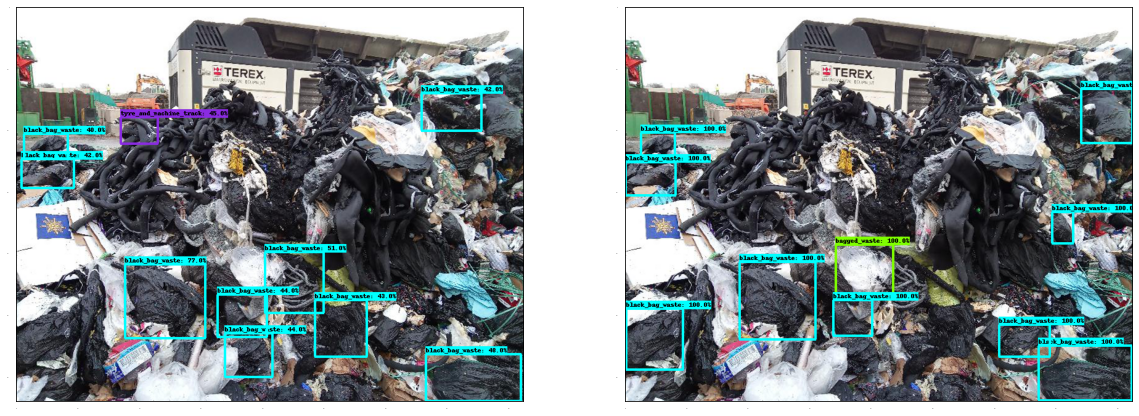

In [70]:
# idx = 3

plt.figure(figsize=(20, 10))
detection = detect(test_image_tensors[idx])

plt.subplot(1, 2, 1)
plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      detection['detection_boxes'][0].numpy(),
      detection['detection_classes'][0].numpy().astype(np.uint32)
      + 1,
      detection['detection_scores'][0].numpy(),
      category_index,
      threshold = 0.4)

plt.subplot(1, 2, 2)
plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      y_test_boxes[idx],
      y_test_classes[idx],
      np.ones(shape=[y_test_classes[idx].shape[0]], dtype=np.float16),
      category_index)

print(idx)
idx += 1

## mAP Block

## mAP - Train

In [71]:
detected_boxes = []
detected_classes = []
detected_scores = []

for i in tqdm(range(len(y_train_classes))):
  detection = detect(train_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+1,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.5)
  detected_boxes.append(detected_box)
  detected_classes.append(detected_class)
  detected_scores.append(detected_score)


In [72]:
p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_train_boxes, 
                          y_train_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5,
                          suppress_output = False)

print(map)

print(sum(map)/num_classes)

# print('\n Trivial: ')

# p, r, map = calculate_map(detected_boxes, 
#                           detected_classes, 
#                           detected_scores, 
#                           y_train_boxes_trivial, 
#                           y_train_classes_trivial, 
#                           num_of_classes = num_classes,
#                           iou_threshold = 0.5)

# print(map)



bagged_waste: 155 annotations
90 / 97 correct detections 

black_bag_waste: 555 annotations
304 / 321 correct detections 

fridge_or_freezer: 17 annotations
17 / 22 correct detections 

gas_bottle_or_cylinder_and_fire_extinguisher: 156 annotations
136 / 160 correct detections 

mattress: 13 annotations
13 / 13 correct detections 

sofa_or_settee_and_chair: 48 annotations
44 / 46 correct detections 

tv_monitor_and_laptop: 3 annotations
3 / 3 correct detections 

tyre_and_machine_track: 108 annotations
82 / 86 correct detections 

WEEE_large: 9 annotations
9 / 9 correct detections 

[0.5607441263563739, 0.5379849467034216, 0.8024284677967979, 0.841066612844187, 0.9230769230769231, 0.8913072729309517, 0.6666666666666667, 0.740704970794691, 0.8888888888888888]
0.7614298751176558


## mAP - Test

In [75]:
detected_boxes = []
detected_classes = []
detected_scores = []

for i in tqdm(range(len(x_test_np))):
  detection = detect(test_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+1,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.4)
  detected_boxes.append(detected_box)
  detected_classes.append(detected_class)
  detected_scores.append(detected_score)

In [76]:
p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_test_boxes, 
                          y_test_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5, 
                          suppress_output = False)

print(map)
print(f'mAP: {sum(map)/num_classes}')

# print('----------------------------------------')
# print('\nExcluding difficult annotations: \n')
# p, r, map = calculate_map(detected_boxes, 
#                           detected_classes, 
#                           detected_scores, 
#                           y_test_boxes_trivial, 
#                           y_test_classes_trivial, 
#                           num_of_classes = num_classes,
#                           iou_threshold = 0.4,
#                           suppress_output = False)

# print(map)
# print(f'mAP: {sum(map)/num_classes}')

bagged_waste: 11 annotations
4 / 13 correct detections 

black_bag_waste: 51 annotations
20 / 38 correct detections 

fridge_or_freezer: 1 annotations
1 / 2 correct detections 

gas_bottle_or_cylinder_and_fire_extinguisher: 2 annotations
0 / 1 correct detections 

mattress: 1 annotations
1 / 1 correct detections 

sofa_or_settee_and_chair: 1 annotations
1 / 3 correct detections 

tv_monitor_and_laptop: 0 annotations
0 / 0 correct detections 

tyre_and_machine_track: 2 annotations
1 / 4 correct detections 

WEEE_large: 0 annotations
0 / 0 correct detections 

[0.07175980585071494, 0.270044601591839, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0]
mAP: 0.06575604527139488


In [ ]:
  
  class_eval = 1
  length = len(detected_boxes)
  detected_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
  detected_classes_eval = [np.array([])]*length
  detected_scores_eval = [np.array([])]*length

  length = len(y_test_classes)
  gt_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
  gt_classes_eval = [np.array([])]*length


  for i, detected_class in enumerate(detected_classes):
    for j, Class in enumerate(detected_class):
      if Class == class_eval:
        detected_classes_eval[i] = np.append(detected_classes_eval[i], detected_classes[i][j])
        detected_boxes_eval[i] = np.vstack([detected_boxes_eval[i], detected_boxes[i][j]])
        detected_scores_eval[i] = np.append(detected_scores_eval[i], detected_scores[i][j])
    if detected_boxes_eval[i].shape[0] == 1:
      detected_boxes_eval[i] = np.array([])
    else:
      detected_boxes_eval[i] = detected_boxes_eval[i][1:]

  for i, gt_class in enumerate(y_test_classes):
    for j, Class in enumerate(gt_class):
      if Class == class_eval:
        gt_classes_eval[i] = np.append(gt_classes_eval[i], y_test_classes[i][j])
        gt_boxes_eval[i] = np.vstack([gt_boxes_eval[i], y_test_boxes[i][j]])
    if gt_boxes_eval[i].shape[0] == 1:
      gt_boxes_eval[i] = np.array([])
    else:
      gt_boxes_eval[i] = gt_boxes_eval[i][1:]

pred_boxes = detected_boxes_eval
gt_boxes = gt_boxes_eval